<a href="https://colab.research.google.com/github/Chourouk-Khetta/Hybrid-Classifier-with-Autoencoder-Features/blob/main/Hybrid_Classifier_with_Autoencoder_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Preprocess the Dataset


In [ ]:
# Install necessary packages
!pip install -q scikit-learn

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import json


In [ ]:
# Load and preprocess Wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

# Check for missing values
print("Missing values per feature:\n", X.isnull().sum())

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nShape of features:", X_scaled.shape)
pd.DataFrame(X_scaled, columns=wine.feature_names).head()


Missing values per feature:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

Shape of features: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


#Build & Train the Autoencoder.

In [ ]:
# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim=13, bottleneck_dim=4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, bottleneck_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)


In [ ]:
# Convert to PyTorch tensors and create DataLoaders
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


###Train the Autoencoder

In [ ]:
# Grid search over hyperparameters (bottleneck_dim and learning rate)
bottleneck_dims = [2, 4, 6]
learning_rates = [0.01, 0.001]
num_epochs = 100

results_hparams = {}

for bottleneck_dim in bottleneck_dims:
    for lr in learning_rates:
        model = Autoencoder(input_dim=13, bottleneck_dim=bottleneck_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for batch in train_loader:
                inputs = batch[0]
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch[0]
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)
                    val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        results_hparams[(bottleneck_dim, lr)] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "final_val_loss": val_losses[-1],
            "model": model
        }

# Select best model based on lowest final validation loss
best_params = min(results_hparams.items(), key=lambda x: x[1]["final_val_loss"])
best_bottleneck, best_lr = best_params[0]
best_model = best_params[1]["model"]

print(f"Best hyperparameters: bottleneck_dim={best_bottleneck}, lr={best_lr}")


Best hyperparameters: bottleneck_dim=6, lr=0.01


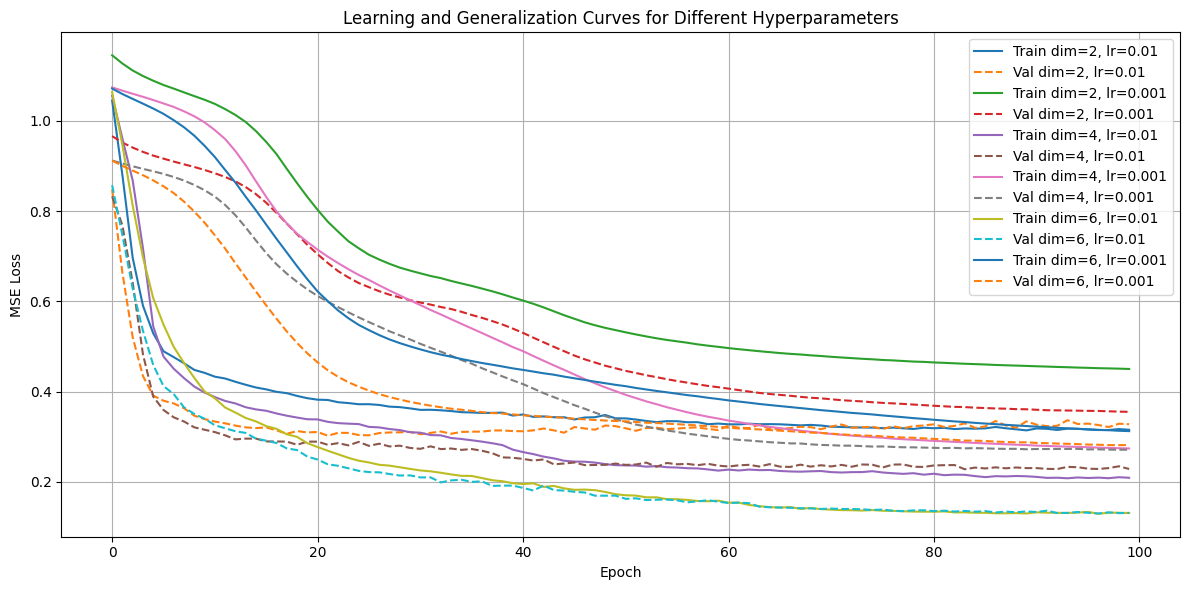

In [ ]:
# Plot learning and generalization curves for all tested hyperparameters
plt.figure(figsize=(12, 6))
for (bottleneck_dim, lr), res in results_hparams.items():
    plt.plot(res["train_losses"], label=f"Train dim={bottleneck_dim}, lr={lr}")
    plt.plot(res["val_losses"], '--', label=f"Val dim={bottleneck_dim}, lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning and Generalization Curves for Different Hyperparameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("autoencoder_hparam_curves.png", dpi=300)
plt.show()


In [ ]:
# Encode data using the best-performing autoencoder
best_model.eval()
with torch.no_grad():
    encoded_features = best_model.encode(X_tensor).numpy()

print("Encoded features shape:", encoded_features.shape)
print(encoded_features[:5])


Encoded features shape: (178, 6)
[[-0.38049477  2.1406035  -1.3069983  -2.4726233  -3.6091692  -1.5143993 ]
 [ 0.04968339  0.98236585  0.7685714  -1.7118808  -1.5865657  -0.83210397]
 [ 0.40666294  2.075221   -1.5546786  -1.3882658  -1.5842056  -0.7805816 ]
 [-1.165319    2.3848634  -1.1738799  -1.4172374  -2.0677075  -0.3739132 ]
 [ 0.39909846  0.37813658 -1.8804623  -1.3922406  -2.0638876  -2.09837   ]]


#GMM Classifier

In [ ]:
# Gaussian Mixture Model classification with 5-fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_components_list = [1, 2, 4, 6]
results = {}

for n_components in n_components_list:
    accuracies = []
    for train_index, test_index in kf.split(encoded_features, y):
        X_train, X_test = encoded_features[train_index], encoded_features[test_index]
        y_train, y_test = y[train_index], y[test_index]

        gmms = {}
        for cls in np.unique(y_train):
            cls_data = X_train[y_train == cls]
            gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, init_params='kmeans')
            gmm.fit(cls_data)
            gmms[cls] = gmm

        y_pred = []
        for x in X_test:
            likelihoods = np.array([gmms[cls].score_samples(x.reshape(1, -1))[0] for cls in np.unique(y_train)])
            y_pred.append(np.unique(y_train)[np.argmax(likelihoods)])

        accuracies.append(accuracy_score(y_test, y_pred))

    results[n_components] = np.mean(accuracies)
    print(f"GMM with {n_components} components: {results[n_components]:.4f}")


GMM with 1 components: 0.9833
GMM with 2 components: 0.9608
GMM with 4 components: 0.8883
GMM with 6 components: 0.9044


#Parzen Window Classifier

In [ ]:
# Parzen Window classification with 5-fold CV
bandwidths = [0.1, 0.5, 1.0, 2.0]
results_pw = {}

for bw in bandwidths:
    accuracies = []
    for train_index, test_index in kf.split(encoded_features, y):
        X_train, X_test = encoded_features[train_index], encoded_features[test_index]
        y_train, y_test = y[train_index], y[test_index]

        kdes = {}
        for cls in np.unique(y_train):
            cls_data = X_train[y_train == cls]
            kde = KernelDensity(kernel='gaussian', bandwidth=bw)
            kde.fit(cls_data)
            kdes[cls] = kde

        y_pred = []
        for x in X_test:
            log_likelihoods = np.array([kdes[cls].score_samples(x.reshape(1, -1))[0] for cls in np.unique(y_train)])
            y_pred.append(np.unique(y_train)[np.argmax(log_likelihoods)])

        accuracies.append(accuracy_score(y_test, y_pred))

    results_pw[bw] = np.mean(accuracies)
    print(f"Parzen Window with bandwidth {bw}: {results_pw[bw]:.4f}")


Parzen Window with bandwidth 0.1: 0.9663
Parzen Window with bandwidth 0.5: 0.9552
Parzen Window with bandwidth 1.0: 0.9663
Parzen Window with bandwidth 2.0: 0.9327


#Additional plots and results for report

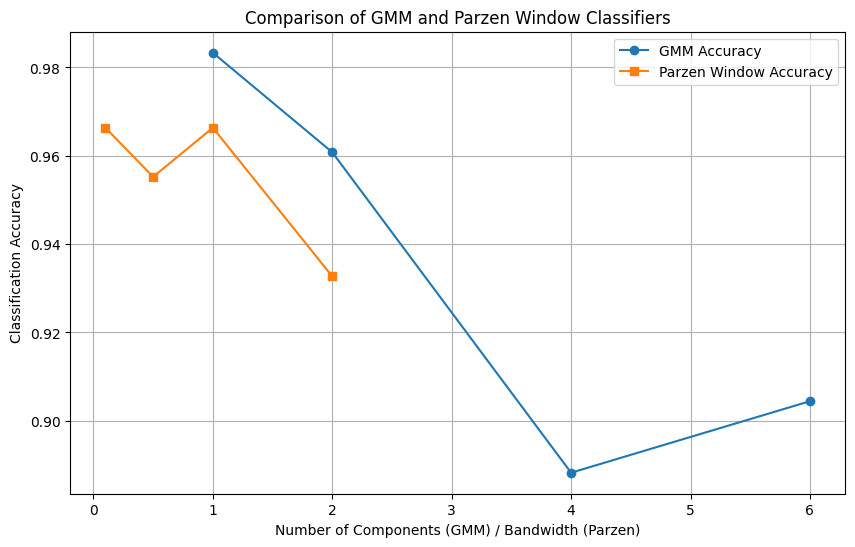

In [ ]:
# Compare results visually
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', label='GMM Accuracy')
plt.plot(list(results_pw.keys()), list(results_pw.values()), marker='s', label='Parzen Window Accuracy')
plt.xlabel('Number of Components (GMM) / Bandwidth (Parzen)')
plt.ylabel('Classification Accuracy')
plt.title('Comparison of GMM and Parzen Window Classifiers')
plt.legend()
plt.grid(True)
plt.savefig("comparison_plot.png", dpi=300)
plt.show()


In [ ]:
# Sort hyperparameter configurations by final validation loss
sorted_hparams = sorted(results_hparams.items(), key=lambda x: x[1]["final_val_loss"])

print("Hyperparameter results (sorted by final validation loss):")
for (bottleneck_dim, lr), res in sorted_hparams:
    print(f"dim={bottleneck_dim}, lr={lr} -> final val loss={res['final_val_loss']:.4f}")


Hyperparameter results (sorted by final validation loss):
dim=6, lr=0.01 -> final val loss=0.1314
dim=4, lr=0.01 -> final val loss=0.2287
dim=4, lr=0.001 -> final val loss=0.2714
dim=6, lr=0.001 -> final val loss=0.2817
dim=2, lr=0.01 -> final val loss=0.3279
dim=2, lr=0.001 -> final val loss=0.3553


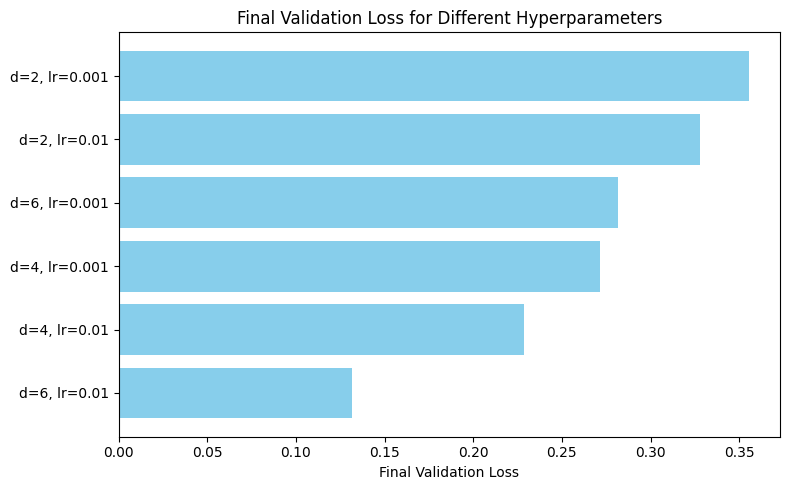

In [ ]:
plt.figure(figsize=(8, 5))
vals = [res["final_val_loss"] for _, res in sorted_hparams]
labels = [f"d={d}, lr={lr}" for (d, lr), _ in sorted_hparams]
plt.barh(labels, vals, color='skyblue')
plt.xlabel("Final Validation Loss")
plt.title("Final Validation Loss for Different Hyperparameters")
plt.tight_layout()
plt.savefig("validation_loss_barplot.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd

# Convert results dictionaries to DataFrame for better visualization
gmm_df = pd.DataFrame(list(results.items()), columns=["Components", "Accuracy"])
parzen_df = pd.DataFrame(list(results_pw.items()), columns=["Bandwidth", "Accuracy"])

print("GMM Accuracy Results:")
print(gmm_df)

print("\nParzen Window Accuracy Results:")
print(parzen_df)


GMM Accuracy Results:
   Components  Accuracy
0           1  0.983333
1           2  0.960794
2           4  0.888254
3           6  0.904444

Parzen Window Accuracy Results:
   Bandwidth  Accuracy
0        0.1  0.966349
1        0.5  0.955238
2        1.0  0.966349
3        2.0  0.932698


In [ ]:
best_gmm = gmm_df.loc[gmm_df["Accuracy"].idxmax()]
best_parzen = parzen_df.loc[parzen_df["Accuracy"].idxmax()]

print(f"Best GMM: {best_gmm['Components']} components with accuracy {best_gmm['Accuracy']:.2%}")
print(f"Best Parzen: bandwidth {best_parzen['Bandwidth']} with accuracy {best_parzen['Accuracy']:.2%}")


Best GMM: 1.0 components with accuracy 98.33%
Best Parzen: bandwidth 0.1 with accuracy 96.63%


/tmp/ipython-input-16-842955809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Best GMM", "Best Parzen"],


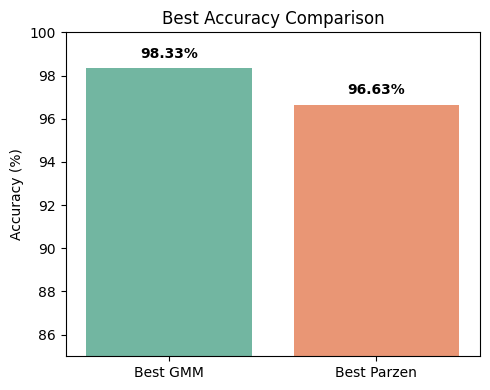

In [ ]:
plt.figure(figsize=(5, 4))
sns.barplot(x=["Best GMM", "Best Parzen"],
            y=[best_gmm["Accuracy"] * 100, best_parzen["Accuracy"] * 100],
            palette="Set2")
plt.title("Best Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(85, 100)
for i, v in enumerate([best_gmm["Accuracy"] * 100, best_parzen["Accuracy"] * 100]):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("best_accuracy_barplot.png", dpi=300)
plt.show()
